Loan prediction contest on Analytics Vidhya.

train = 
       Loan_ID  Gender Married  ... Credit_History Property_Area Loan_Status
5    LP001011    Male     Yes  ...            1.0         Urban           Y
438  LP002403    Male      No  ...            0.0         Urban           N
124  LP001439    Male     Yes  ...            1.0         Rural           Y
540  LP002741  Female     Yes  ...            1.0     Semiurban           Y
421  LP002357  Female      No  ...            0.0         Urban           N

[5 rows x 13 columns] 



train_X = (614, 11)
train_Y = (614,)
test_X = (367, 11)


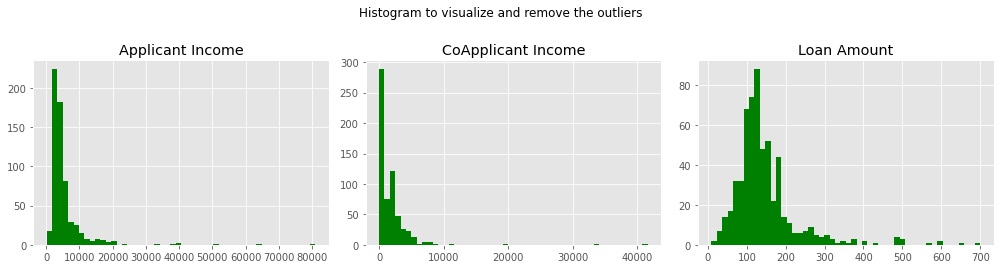

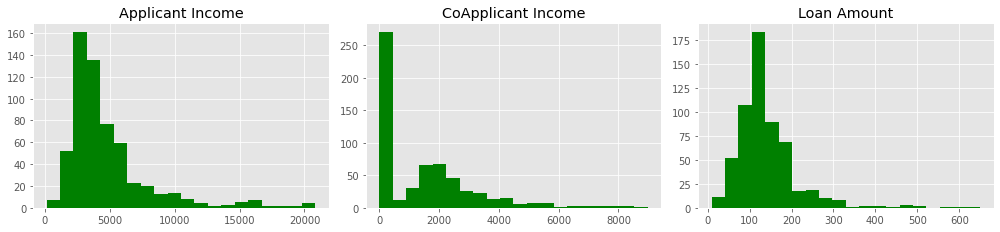

train_X = (600, 11)
train_Y = (600,) 



Epoch 1/2000
2/2 [==============================] - 1s 8ms/step - loss: 0.6904 - accuracy: 0.4321
Epoch 2/2000
2/2 [==============================] - 0s 6ms/step - loss: 0.6006 - accuracy: 0.6924
Epoch 3/2000
2/2 [==============================] - 0s 6ms/step - loss: 0.5682 - accuracy: 0.6951
Epoch 4/2000
2/2 [==============================] - 0s 6ms/step - loss: 0.5467 - accuracy: 0.7209
Epoch 5/2000
2/2 [==============================] - 0s 5ms/step - loss: 0.5329 - accuracy: 0.7936
Epoch 6/2000
2/2 [==============================] - 0s 5ms/step - loss: 0.5117 - accuracy: 0.8186
Epoch 7/2000
2/2 [==============================] - 0s 4ms/step - loss: 0.4984 - accuracy: 0.8148
Epoch 8/2000
2/2 [==============================] - 0s 5ms/step - loss: 0.4943 - accuracy: 0.8153
Epoch 9/2000
2/2 [==============================] - 0s 4ms/step - loss: 0.4834 - accuracy: 0.8099
Epoch 10/2000
2/2 [==============================] - 0s 6ms/step - loss: 0.46

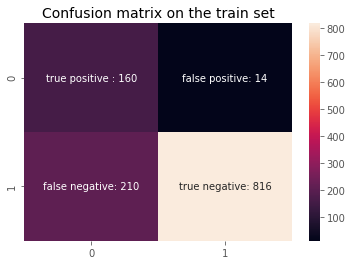

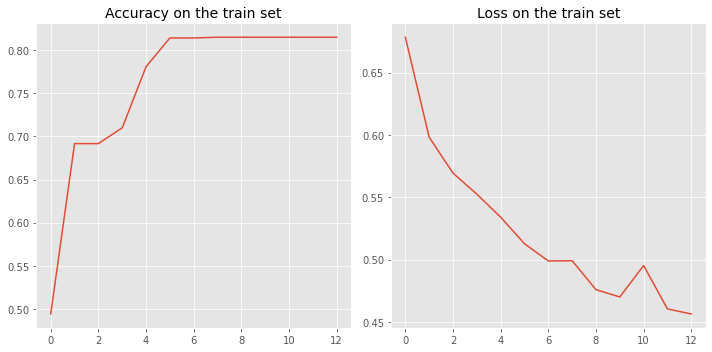

In [37]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.utils import shuffle
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten, BatchNormalization
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import SelectKBest, chi2
plt.style.use('ggplot')

# Read the data
train = pd.read_csv('train.csv')
train = shuffle(train)
test_X = pd.read_csv('test.csv')
print('train = \n', train.head(), '\n'*3)

# Prepare the train and the test set
train.pop('Loan_ID')
train_X = train
loan_id = test_X.pop('Loan_ID')
train_Y = train.pop('Loan_Status')
print('train_X =', train_X.shape)
print('train_Y =', train_Y.shape)
print('test_X =', test_X.shape)

# Histogram to check outliers
plt.figure(figsize=(14,9))
plt.subplot(331)
train_X['ApplicantIncome'].hist(bins=50, color='green')
plt.title('Applicant Income')
plt.tight_layout()
plt.subplot(332)
train_X['CoapplicantIncome'].hist(bins=50, color='green')
plt.title('CoApplicant Income')
plt.subplot(333)
train_X['LoanAmount'].hist(bins=50, color='green')
plt.title('Loan Amount')
plt.tight_layout()
plt.suptitle('Histogram to visualize and remove the outliers', fontsize=12, y=1.04)
plt.show()


#Reomve outliers from the train set using quartiles
for column in ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']:
  if column == 'LoanAmount':
    th1, th2 = np.percentile(train_X[column],[10,90])
    iqr = th2 - th1
    lower_bound = th1 -(1.5 * iqr) 
    upper_bound = th2 +(1.5 * iqr)
    indeces= train_X[(train_X[column] > upper_bound) | (train_X[column] < lower_bound) ].index
    train_X.drop(indeces, inplace=True)
    train_Y.drop(indeces, inplace=True)
  else:
    th1, th2 = np.percentile(train_X[column],[0,90])
    iqr = th2 - th1
    lower_bound = th1 -(1.5 * iqr) 
    upper_bound = th2 +(1.5 * iqr)
    indeces= train_X[(train_X[column] > upper_bound) | (train_X[column] < lower_bound) ].index
    train_X.drop(indeces, inplace=True)
    train_Y.drop(indeces, inplace=True)
train_size = train_X.shape

plt.figure(figsize=(14,9))
plt.subplot(331)
train_X['ApplicantIncome'].hist(bins=20, color='green')
plt.title('Applicant Income')
plt.tight_layout()
plt.subplot(332)
train_X['CoapplicantIncome'].hist(bins=20, color='green')
plt.title('CoApplicant Income')
plt.subplot(333)
train_X['LoanAmount'].hist(bins=20, color='green')
plt.title('Loan Amount')
plt.tight_layout()
plt.show()  

print('train_X =', train_X.shape)
print('train_Y =', train_Y.shape, '\n'*3)


# convert values to numerical
# One-hot encoding
train_X = pd.get_dummies(train_X, columns=["Gender","Married"])
test_X = pd.get_dummies(test_X, columns=["Gender","Married"])

# Frequency encoding
# pa = train_X.groupby('Property_Area').size()/len(train_X)
# dep = train_X.groupby('Dependents').size()/len(train_X)
# edu = train_X.groupby('Education').size()/len(train_X)
# emp = train_X.groupby('Self_Employed').size()/len(train_X)
# train_X['Property_Area'] = train_X['Property_Area'].map(pa)
# train_X['Dependents'] = train_X['Dependents'].map(dep)
# train_X['Education'] = train_X['Education'].map(edu)
# train_X['Self_Employed'] = train_X['Self_Employed'].map(emp)
# test_X['Property_Area'] = test_X['Property_Area'].map(pa)
# test_X['Dependents'] = test_X['Dependents'].map(dep)
# test_X['Education'] = test_X['Education'].map(edu)
# test_X['Self_Employed'] = test_X['Self_Employed'].map(emp)

# Label and oridinal encoding
train_X['Property_Area'] = [2.0 if x=='Urban' else 1.0 if x=='Semiurban'
                             else 0.0 for x in train_X['Property_Area']]  
test_X['Property_Area'] = [2.0 if x=='Urban' else 1.0 if x=='Semiurban'
                             else 0.0 for x in test_X['Property_Area']] 
train_X['Dependents'] = [0.0 if x=='0' else 1.0 if x=='1' else 2.0 if x=='2'
                    else 3 for x in train_X['Dependents']]    
test_X['Dependents'] = [0.0 if x=='0' else 1.0 if x=='1' else 2.0 if x=='2'
                    else 3 for x in test_X['Dependents']] 
train_X['Education'] = [1.0 if x=='Graduate' else 0.0 for x in train_X['Education']]
train_X['Self_Employed'] = [1.0 if x=='Yes' else 0.0 for x in train_X['Self_Employed']]
test_X['Education'] = [1.0 if x=='Graduate' else 0.0 for x in test_X['Education']]
test_X['Self_Employed'] = [1.0 if x=='Yes' else 0.0 for x in test_X['Self_Employed']]
train_Y = [1.0 if x=='Y' else 0.0 for x in train_Y]


"""Fill missing values"""
# ffill method
# train_X['Loan_Amount_Term'].fillna(method='bfill', inplace=True)
# test_X['Loan_Amount_Term'].fillna(method='bfill', inplace=True)

# train_X['Credit_History'].fillna(method='bfill', inplace=True)
# test_X['Credit_History'].fillna(method='bfill', inplace=True)

# train_X['LoanAmount'].fillna(method='bfill', inplace=True)
# test_X['LoanAmount'].fillna(method='bfill', inplace=True)

# impute with mean, mode or median
train_X['Loan_Amount_Term'].fillna(train_X['Loan_Amount_Term'].median(), inplace=True)
test_X['Loan_Amount_Term'].fillna(train_X['Loan_Amount_Term'].median(), inplace=True)

train_X['Credit_History'].fillna(train_X['Credit_History'].median(), inplace=True)
test_X['Credit_History'].fillna(train_X['Credit_History'].median(), inplace=True)

train_X['LoanAmount'].fillna(train_X['LoanAmount'].median(), inplace=True)
test_X['LoanAmount'].fillna(train_X['LoanAmount'].median(), inplace=True)


# Add data
train_X = pd.concat([train_X, train_X[::-1]], ignore_index=True)
train_Y = train_Y + train_Y[::-1]

# Add columns
# train_X['1'] = [10 if x==1 else 0 if x==0 else 5 for x in train_X['Credit_History']]
# test_X['1'] = [10 if x==1 else 0 if x==0 else 5 for x in test_X['Credit_History']]
# train_X['2'] = [x**2 for x in train_X['Property_Area']]
# test_X['2'] = [x**2 for x in test_X['Property_Area']]


# Normalize the data
scaler = MinMaxScaler()
df = pd.concat([train_X, test_X], ignore_index=True)
df = scaler.fit_transform(df)
#train_X = pd.DataFrame(train_X, index=train_X.index, columns=train_X.columns)
#test_X = pd.DataFrame(test_X, index=test_X.index, columns=test_X.columns)
m = train_X.shape[0]
train_X = df[:m]
test_X = df[m:]
train_Y = np.asarray(train_Y, dtype='float64')

# Build the model
def build_model():
  adam = tf.keras.optimizers.Adam(
    learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False)
  callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=5)

  inputs = Input(shape=(13,), name='input_layer')
  x = Dense(units=128, activation='relu')(inputs)
  x = Dense(units=1, name='Output', activation='sigmoid')(x)
  model =  Model(inputs=inputs, outputs=x)

  model.compile(optimizer='RMSprop', loss='binary_crossentropy', metrics='accuracy')
  history = model.fit(train_X, train_Y, batch_size=614,
                      epochs=2000, verbose=1, callbacks=[callback])
  return [model, history]

[model, history] = build_model()
predictions = model.predict(test_X)
pred = ['Y' if x>=0.5 else 'N' for x in predictions]
pred_dic = list(zip(loan_id, pred))
pred_df = pd.DataFrame(pred_dic, columns=['Loan_ID', 'Loan_Status'])
pred_df.to_csv ('predict.csv', index = False, header=True)

# Confusion matrix on the train set
train_pred = model.predict(train_X)
train_pred = [1 if x >=0.5 else 0 for x in train_pred]
CM = confusion_matrix(train_pred, train_Y)
labels = np.array(['true positive : %i' %CM[0][0] , 'false positive: %i' %CM[0][1],
                  'false negative: %i'%CM[1][0], 'true negative: %i'%CM[1][1]])
labels = labels.reshape((2,2))
sns.heatmap(CM, annot=labels, cmap=None, fmt='');
plt.title('Confusion matrix on the train set', fontsize=14)
plt.show()

# Accuracy and loss 
results = history.history
epochs = len(history.history['loss'])
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(np.arange(epochs), results['accuracy'])
plt.title('Accuracy on the train set', fontsize=14)
plt.subplot(122)
plt.plot(np.arange(epochs), results['loss'])
plt.title('Loss on the train set', fontsize=14)
plt.tight_layout()
plt.show()